# Figure 5: Leading authors

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm


import plot_info # Does this set the plot style ? Yes it does

assessment_columns = plot_info.assessment_columns

leading_author_claims = pd.read_csv("preprocessed_data/leading_author_claims.csv")

# Map assessment types to standardized categories
leading_author_claims['assessment_type_grouped'] = leading_author_claims['assessment_type'].apply(plot_info.group_assessment)


def create_author_metric(author_claims):
    # Create base aggregation with name, counts, and article counts
    author_base = leading_author_claims.groupby('last_author_key').agg(**{
        "Name":('Name', 'first'),
        "Major claims":('id', 'count'),
        "Articles":('article_id', 'nunique')
        }
    )

    # Create a cross-tabulation of first_author_key and assessment_type_grouped
    assessment_counts = pd.crosstab(
        leading_author_claims['last_author_key'], 
        leading_author_claims['assessment_type_grouped']
    )

    # Make sure all assessment columns exist (some might be missing if no authors had that type)
    for col in assessment_columns:
        if col not in assessment_counts.columns:
            assessment_counts[col] = 0

    # Combine the base metrics with assessment counts
    author_metrics = pd.concat([author_base, assessment_counts], axis=1)


    for col in assessment_columns:
        author_metrics[f'{col} prop'] = author_metrics[col] / author_metrics['Major claims']

    author_metrics = author_metrics.reset_index()

    return author_metrics

author_metrics = create_author_metric(leading_author_claims)
author_metrics_after_2000 = create_author_metric(leading_author_claims[leading_author_claims['year'] > 2000])

In [2]:
leading_author_claims.columns

Index(['id', 'content', 'article_id', 'rank', 'pmid', 'authors_txt', 'title',
       'pmid_article', 'volume', 'issue', 'abstract', 'year', 'journal_name',
       'impact_factor', 'first_author_extracted', 'last_author_extracted',
       'primary_affiliation', 'country', 'assertion_type', 'label',
       'is_assessed', 'assessment_type', 'rank_assessment_type', 'author_id',
       'name', 'sex', 'leading_author', 'first_author', 'career_stage',
       'expertise_level', 'author_key', 'Name', 'Historical lab',
       'Historical lab after 1998', 'Continuity', 'F and L', 'Sex',
       'Start lab', 'Finish', 'Authorship', 'last_author_key', 'Junior Senior',
       'assessment_type_grouped'],
      dtype='object')

In [3]:
print(len(author_metrics))
author_metrics = author_metrics[(author_metrics["Major claims"] >= 6) & (author_metrics["Articles"] >= 2)]
# TODO update all with this ?
print(len(author_metrics))

157
49


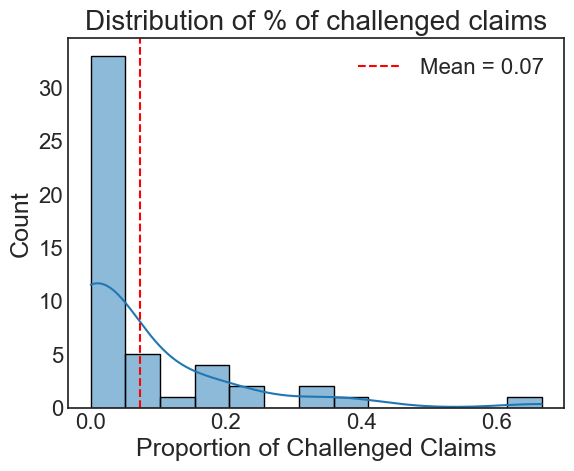

Descriptive Statistics:


,Unchallenged,Verified,Partially Verified,Mixed,Challenged,Unchallenged prop,Verified prop,Partially Verified prop,Mixed prop,Challenged prop,Challenged prop,Articles,Major claims
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,3.163265,9.020408,1.183673,0.163265,1.040816,0.237232,0.591910,0.084940,0.012819,0.073098,0.073098,5.571429,14.571429
std,3.368648,10.190866,1.394535,0.514253,1.695081,0.217985,0.250111,0.096773,0.043569,0.133925,0.133925,5.024938,13.060755
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000
25%,1.000000,4.000000,0.000000,0.000000,0.000000,0.043478,0.451613,0.000000,0.000000,0.000000,0.000000,3.000000,6.000000
50%,2.000000,6.000000,1.000000,0.000000,0.000000,0.181818,0.631579,0.066667,0.000000,0.000000,0.000000,4.000000,10.000000
75%,5.000000,10.000000,2.000000,0.000000,2.000000,0.375000,0.777778,0.142857,0.000000,0.100000,0.100000,6.000000,16.000000
max,17.000000,47.000000,6.000000,2.000000,7.000000,0.857143,1.000000,0.375000,0.181818,0.666667,0.666667,28.000000,67.000000


In [4]:
descriptive_stats = author_metrics[assessment_columns + [col + ' prop' for col in assessment_columns] + 
                    ['Challenged prop', 'Articles', 'Major claims']].describe()

sns.histplot(author_metrics['Challenged prop'], kde=True)
plt.title('Distribution of % of challenged claims')
plt.xlabel('Proportion of Challenged Claims')
plt.axvline(author_metrics['Challenged prop'].mean(), color='red', linestyle='--', 
            label=f'Mean = {author_metrics["Challenged prop"].mean():.2f}')
plt.legend()
plt.show()
print("Descriptive Statistics:")
descriptive_stats

## A. Distribution plot

Our analysis will focus on the 49 PIs who published at least 6 major claims from aminimum of 2 articles
Among the 49 PIs, we identified 11 laboratories where more than 10% of the claims were challenged, with the highest proportion reaching 66.66666666666666% 


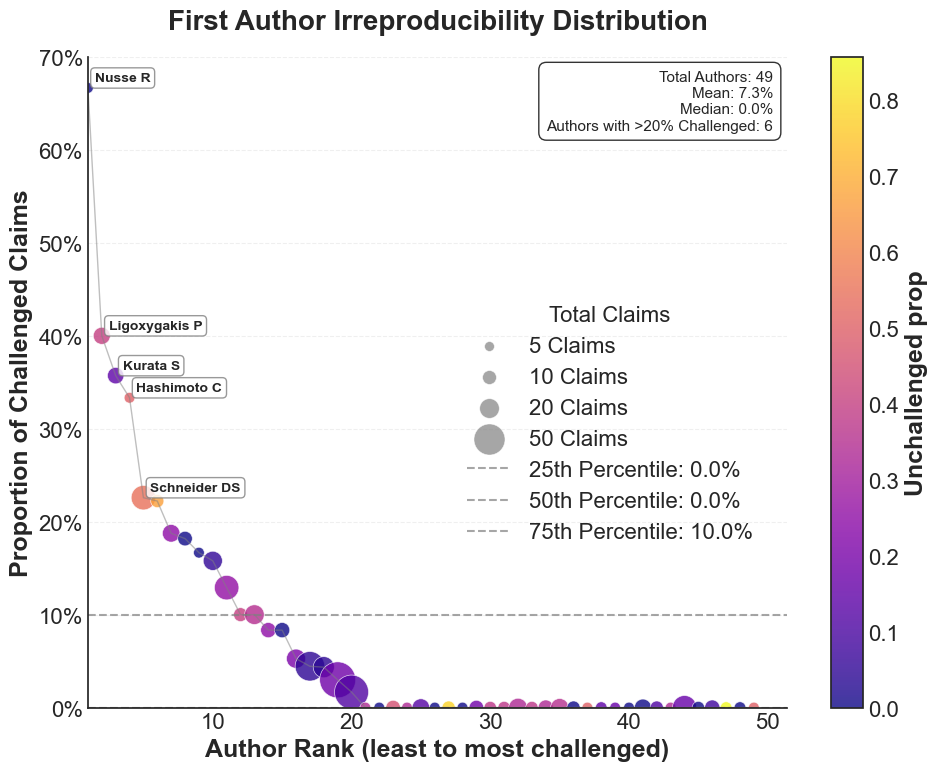

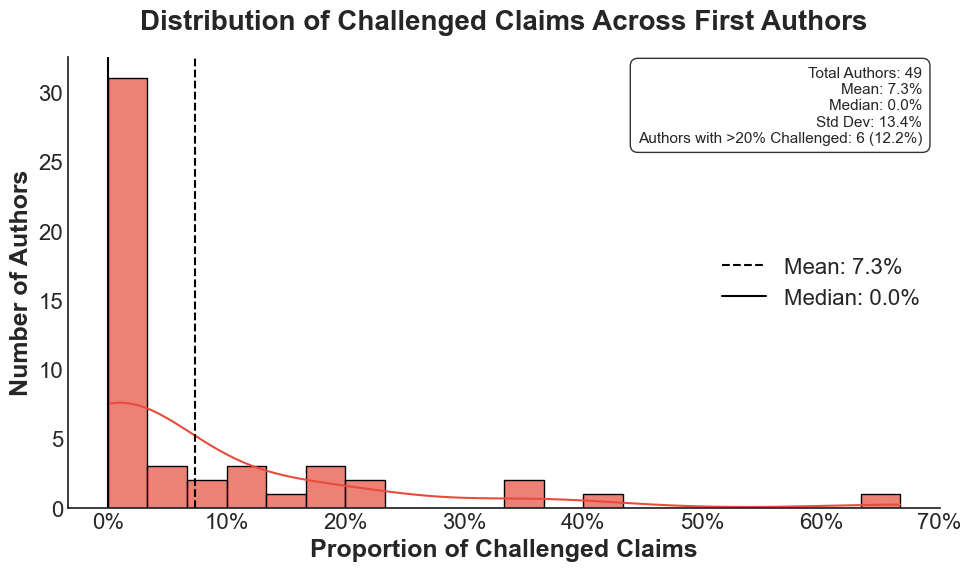

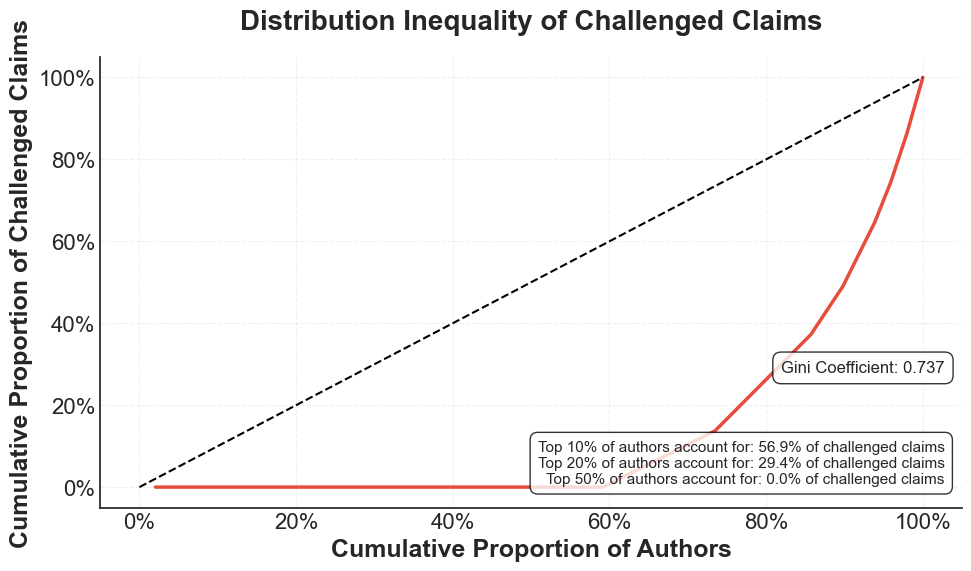

In [5]:
to_plot = author_metrics.copy()
min_articles = 2
min_claims = 6
to_plot = to_plot[to_plot['Articles'] >= min_articles]
to_plot = to_plot[to_plot['Major claims'] >= min_claims]
print(f"Our analysis will focus on the {len(to_plot)} PIs who published at least {min_claims} major claims from a"
      f"minimum of {min_articles} articles")
print(f"Among the {len(to_plot)} PIs, we identified {len(to_plot[to_plot['Challenged prop']>.1])} laboratories "
      f"where more than 10% of the claims were challenged, with the highest proportion reaching"
      f" {max(to_plot['Challenged prop']*100)}% ")


fig, ax = plot_info.plot_author_irreproducibility_focused(
    df=to_plot,
    title="First Author Irreproducibility Distribution",
    color_by='Unchallenged prop',
    cmap='plasma',  # Choose colormap that doesn't have white at minimum
    most_challenged_on_right=True
)
plt.savefig('figures/fig5A-V1.png', dpi=300, bbox_inches='tight')
fig1, ax1 = plot_info.plot_challenged_histogram(to_plot)
plt.savefig('figures/fig5A-V2.png', dpi=300, bbox_inches='tight')

# Create Lorenz curve visualization
fig2, ax2 = plot_info.plot_lorenz_curve(to_plot)
plt.savefig('figures/fig5A-V3.png', dpi=300, bbox_inches='tight')

In [6]:
author_metrics

,last_author_key,Name,Major claims,Articles,Challenged,Mixed,Partially Verified,Unchallenged,Verified,Unchallenged prop,Verified prop,Partially Verified prop,Mixed prop,Challenged prop
3,anderson kv,Anderson KV,20,8,2,0,0,7,11,0.350000,0.550000,0.000000,0.000000,0.100000
4,ando i,Andó I,12,6,0,0,4,1,7,0.083333,0.583333,0.333333,0.000000,0.000000
23,courey aj,Courey AJ,6,2,0,1,1,0,4,0.000000,0.666667,0.166667,0.166667,0.000000
35,engstrom y,Engström Y,11,6,0,0,1,2,8,0.181818,0.727273,0.090909,0.000000,0.000000
36,ezekowitz ra,Ezekowitz RA,16,6,3,0,1,4,8,0.250000,0.500000,0.062500,0.000000,0.187500
37,fauvarque mo,Fauvarque MO,8,3,0,0,0,3,5,0.375000,0.625000,0.000000,0.000000,0.000000
40,ferrandon d,Ferrandon D,18,7,0,0,1,6,11,0.333333,0.611111,0.055556,0.000000,0.000000
43,franc nc,Franc NC,6,2,1,0,1,0,4,0.000000,0.666667,0.166667,0.000000,0.166667
46,gateff e,Gateff E,6,3,0,0,0,0,6,0.000000,1.000000,0.000000,0.000000,0.000000
47,gay nj,Gay NJ,11,4,2,2,0,0,7,0.000000,0.636364,0.000000,0.181818,0.181818


In [7]:
leading_author_claims.columns

Index(['id', 'content', 'article_id', 'rank', 'pmid', 'authors_txt', 'title',
       'pmid_article', 'volume', 'issue', 'abstract', 'year', 'journal_name',
       'impact_factor', 'first_author_extracted', 'last_author_extracted',
       'primary_affiliation', 'country', 'assertion_type', 'label',
       'is_assessed', 'assessment_type', 'rank_assessment_type', 'author_id',
       'name', 'sex', 'leading_author', 'first_author', 'career_stage',
       'expertise_level', 'author_key', 'Name', 'Historical lab',
       'Historical lab after 1998', 'Continuity', 'F and L', 'Sex',
       'Start lab', 'Finish', 'Authorship', 'last_author_key', 'Junior Senior',
       'assessment_type_grouped'],
      dtype='object')

## B. Binary variables

Summary of Historical lab after 1998:
                           Major claims  Articles  Verified_prop  \
Historical lab after 1998                                          
False                               567       229       0.509700   
True                                263       100       0.726236   

                           Challenged_prop  Unchallenged_prop  
Historical lab after 1998                                      
False                             0.088183           0.312169  
True                              0.049430           0.140684  
Index([False, True], dtype='bool', name='Historical lab after 1998')
Summary of Continuity:
            Major claims  Articles  Verified_prop  Challenged_prop  \
Continuity                                                           
False                186        72       0.516129         0.086022   
True                 528       201       0.655303         0.066288   

            Unchallenged_prop  
Continuity                  

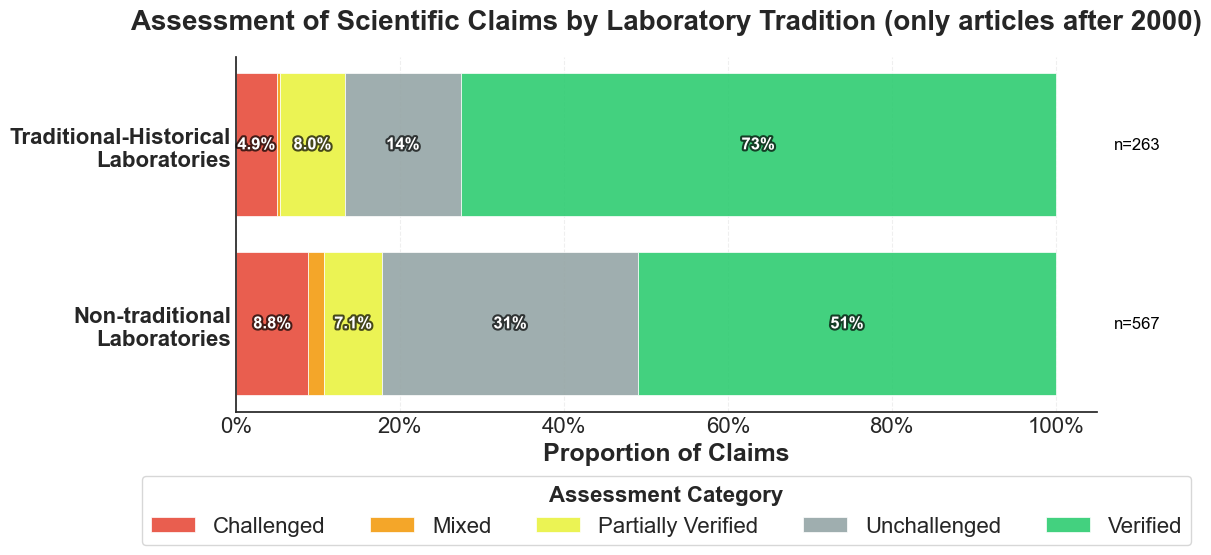

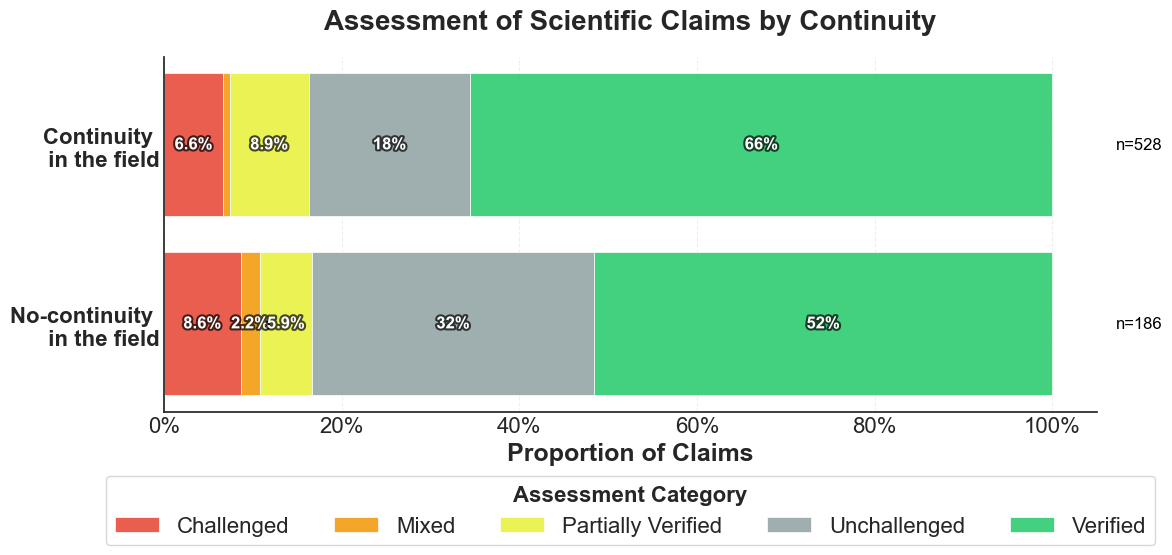

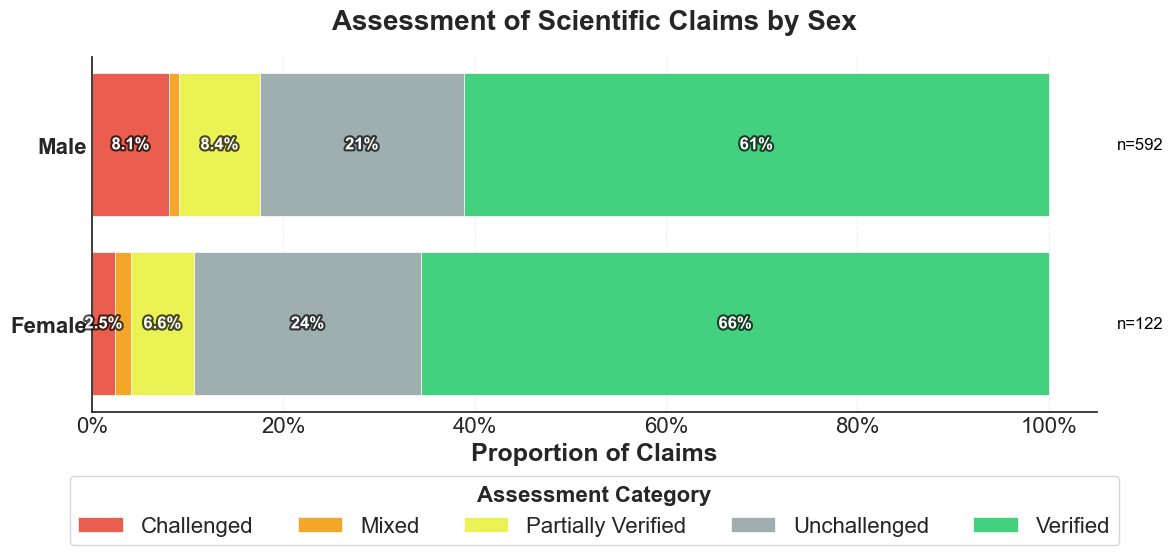

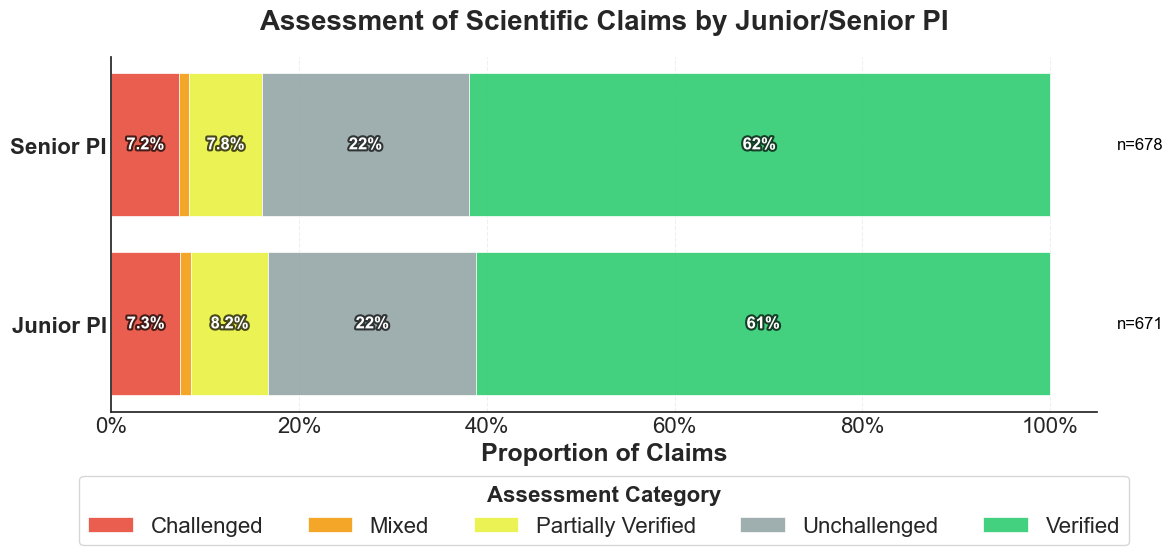

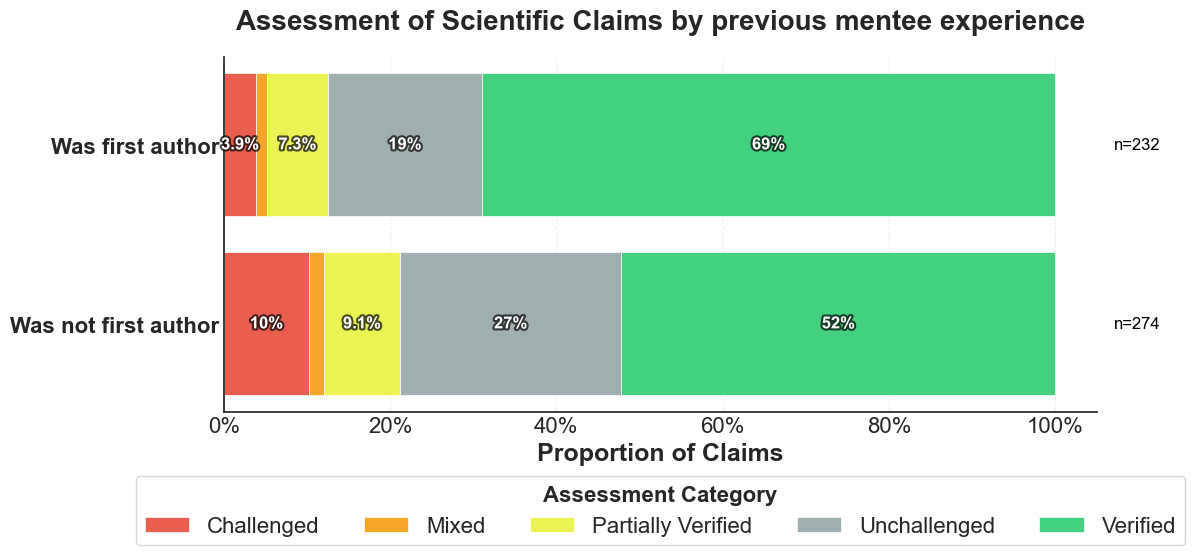

In [8]:
all_categorical_variables = {
            "Historical lab after 1998": {
                "labels": ['Non-traditional\nLaboratories', 'Traditional-Historical\nLaboratories'],
                "title": "Assessment of Scientific Claims by Laboratory Tradition (only articles after 2000)",
                "fig_name_prefix" : "fig5E_"
                },
            "Continuity": {
                "labels": ['No-continuity \n in the field', 'Continuity \n in the field'],
                "title": "Assessment of Scientific Claims by Continuity",
                "fig_name_prefix" : "fig6A_"
                },
            "Sex": {
                "labels": ["Female", "Male"], # check if this is correct -> Yes, this is correct
                "title": "Assessment of Scientific Claims by Sex",
                "fig_name_prefix" : "fig5B_",
                },
            "Junior Senior": {
                "labels": ["Junior PI", "Senior PI"],
                "title": "Assessment of Scientific Claims by Junior/Senior PI",
                "fig_name_prefix" : "fig5D_"
                },
            "F and L": {
                "labels": ["Was not first author", "Was first author"],
                "title": "Assessment of Scientific Claims by previous mentee experience",
                "fig_name_prefix" : "fig5F_"
                },
        }


for variable in all_categorical_variables.keys():
    # Group by historical lab status
    if variable == "Historical lab after 1998":
        author_metrics_to_plot = author_metrics_after_2000
    else:
        author_metrics_to_plot = author_metrics
    var_grouped = plot_info.prepare_categorical_variable_data(leading_author_claims, 
                                                    author_metrics_to_plot, variable, 
                                                    key_col='last_author_key',
                                                    assessment_columns=assessment_columns)

    # Calculate proportions
    for col in assessment_columns:
        var_grouped[f'{col}_prop'] = var_grouped[col] / var_grouped['Major claims']

    print(f"Summary of {variable}:")
    print(var_grouped[['Major claims', 'Articles', 
                        'Verified_prop', 'Challenged_prop', 'Unchallenged_prop']])
    print(var_grouped.index)
    
    labels=all_categorical_variables[variable]["labels"]
    if variable == "Career Stage":
        # Use the labels from the data
        labels = var_grouped.index

    fig, ax = plot_info.create_horizontal_bar_chart(var_grouped, show_p_value=False, labels=labels, title=all_categorical_variables[variable]["title"])
    plt.savefig(f"figures/{all_categorical_variables[variable]['fig_name_prefix']}categorical_{variable}.png", dpi=300, bbox_inches='tight')


In [9]:
to_plot = author_metrics.copy()

In [10]:
to_plot['Articles'].sort_values(ascending=False)

63     28
78     21
62     16
124    12
77     12
65     11
114     9
3       8
141     7
40      7
112     6
36      6
131     6
119     6
35      6
4       6
116     6
89      5
81      5
64      5
127     5
47      4
80      4
156     4
74      4
133     4
134     4
151     4
69      4
117     3
110     3
46      3
37      3
75      3
102     3
84      3
79      3
73      2
68      2
23      2
101     2
43      2
56      2
50      2
135     2
49      2
146     2
48      2
107     2
Name: Articles, dtype: int64

/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_12501/3149843978.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = to_plot.groupby('Article_bin')['Challenged prop'].median()


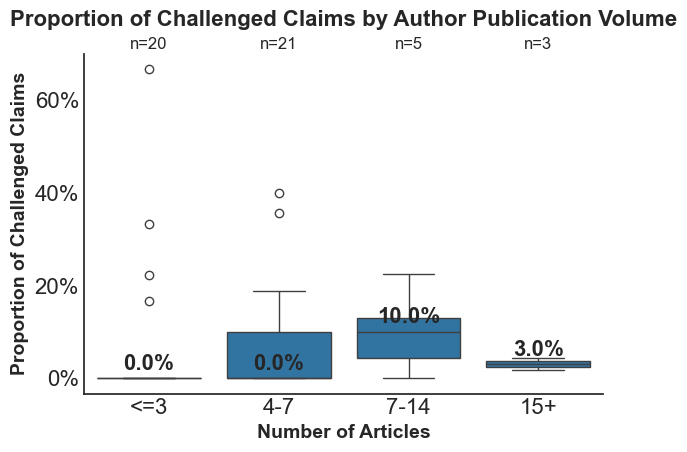

In [11]:

# Create article count bins
article_bins = [.5, 3.5, 7.5, 14.5,  float('inf')]
bin_labels =     ['<=3', '4-7', '7-14', '15+']
to_plot['Article_bin'] = pd.cut(to_plot['Articles'], bins=article_bins, labels=bin_labels)

# Create the boxplot
ax = sns.boxplot(x='Article_bin', y='Challenged prop', data=to_plot)
#ax = sns.stripplot(x='Article_bin', y='Challenged prop', data=to_plot, alpha=0.3, jitter=True, jitter_size=.95, color='black')

# Add individual data points
#sns.stripplot(x='Article_bin', y='Challenged prop', data=to_plot, 
#              color='black', alpha=0.3, jitter=True)

# Add count annotations below each category
for i, cat in enumerate(bin_labels):
    count = len(to_plot[to_plot['Article_bin'] == cat])
    ax.text(i, 1.05, f"n={count}", ha='center', va='top', fontsize=12,
            transform=ax.get_xaxis_transform())

# Format the y-axis as percentage
ax.yaxis.set_major_formatter(plot_info.PercentFormatter(1.0))

# Add labels and title
plt.xlabel('Number of Articles', fontsize=14, fontweight='bold')
plt.ylabel('Proportion of Challenged Claims', fontsize=14, fontweight='bold')
plt.title('Proportion of Challenged Claims by Author Publication Volume', 
          fontsize=16, fontweight='bold', pad=20)

# Add median values on top of each box
medians = to_plot.groupby('Article_bin')['Challenged prop'].median()
for i, m in enumerate(medians):
    ax.text(i, m + 0.01, f"{m:.1%}", ha='center', va='bottom', fontweight='bold')

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.savefig('figures/fig5C-nb_article_V1.png', dpi=300, bbox_inches='tight')

In [12]:
to_plot

,last_author_key,Name,Major claims,Articles,Challenged,Mixed,Partially Verified,Unchallenged,Verified,Unchallenged prop,Verified prop,Partially Verified prop,Mixed prop,Challenged prop,Article_bin
3,anderson kv,Anderson KV,20,8,2,0,0,7,11,0.350000,0.550000,0.000000,0.000000,0.100000,7-14
4,ando i,Andó I,12,6,0,0,4,1,7,0.083333,0.583333,0.333333,0.000000,0.000000,4-7
23,courey aj,Courey AJ,6,2,0,1,1,0,4,0.000000,0.666667,0.166667,0.166667,0.000000,<=3
35,engstrom y,Engström Y,11,6,0,0,1,2,8,0.181818,0.727273,0.090909,0.000000,0.000000,4-7
36,ezekowitz ra,Ezekowitz RA,16,6,3,0,1,4,8,0.250000,0.500000,0.062500,0.000000,0.187500,4-7
37,fauvarque mo,Fauvarque MO,8,3,0,0,0,3,5,0.375000,0.625000,0.000000,0.000000,0.000000,<=3
40,ferrandon d,Ferrandon D,18,7,0,0,1,6,11,0.333333,0.611111,0.055556,0.000000,0.000000,4-7
43,franc nc,Franc NC,6,2,1,0,1,0,4,0.000000,0.666667,0.166667,0.000000,0.166667,<=3
46,gateff e,Gateff E,6,3,0,0,0,0,6,0.000000,1.000000,0.000000,0.000000,0.000000,<=3
47,gay nj,Gay NJ,11,4,2,2,0,0,7,0.000000,0.636364,0.000000,0.181818,0.181818,4-7


### Continuous Variables

/Users/chadi/Research/drosophila-reproducibility/plot_info.py:1389: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


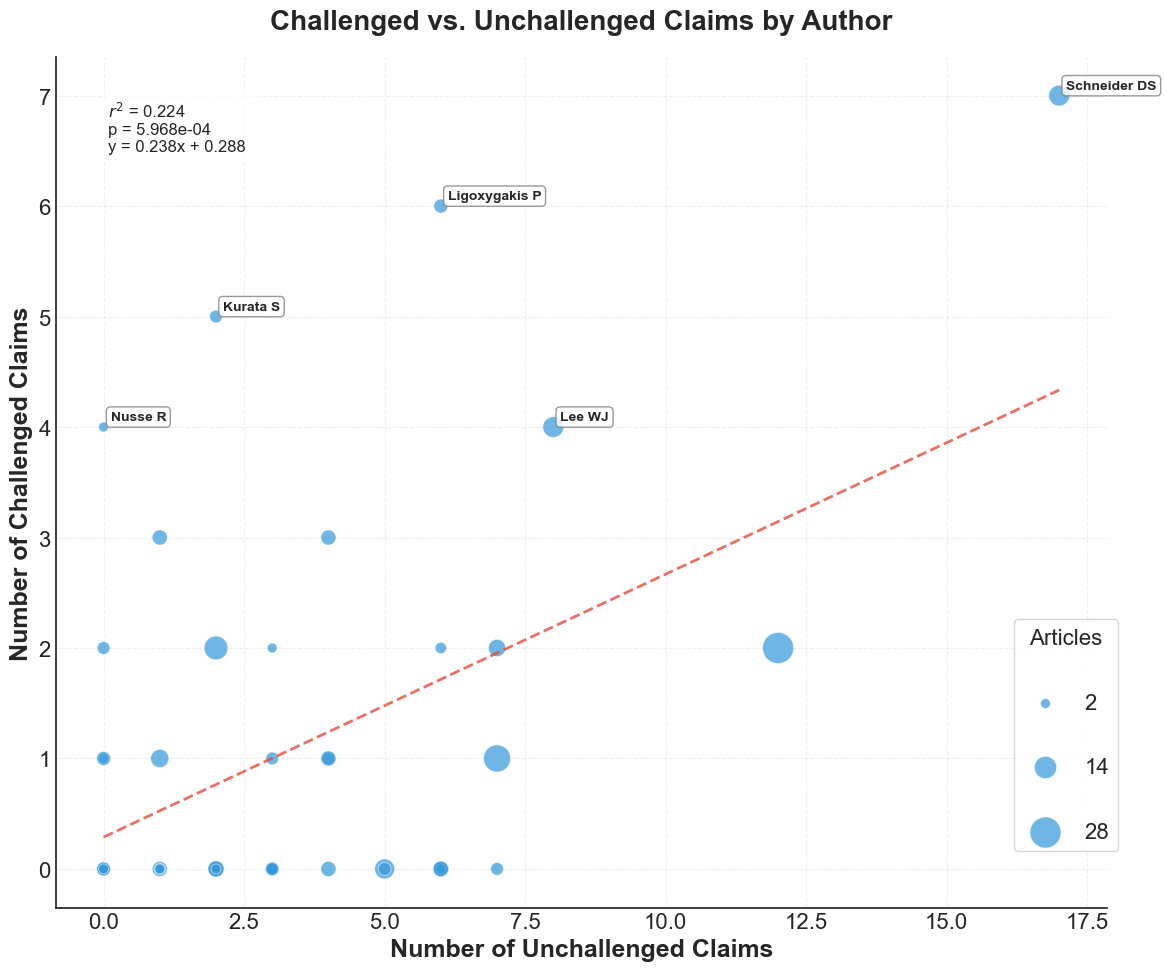

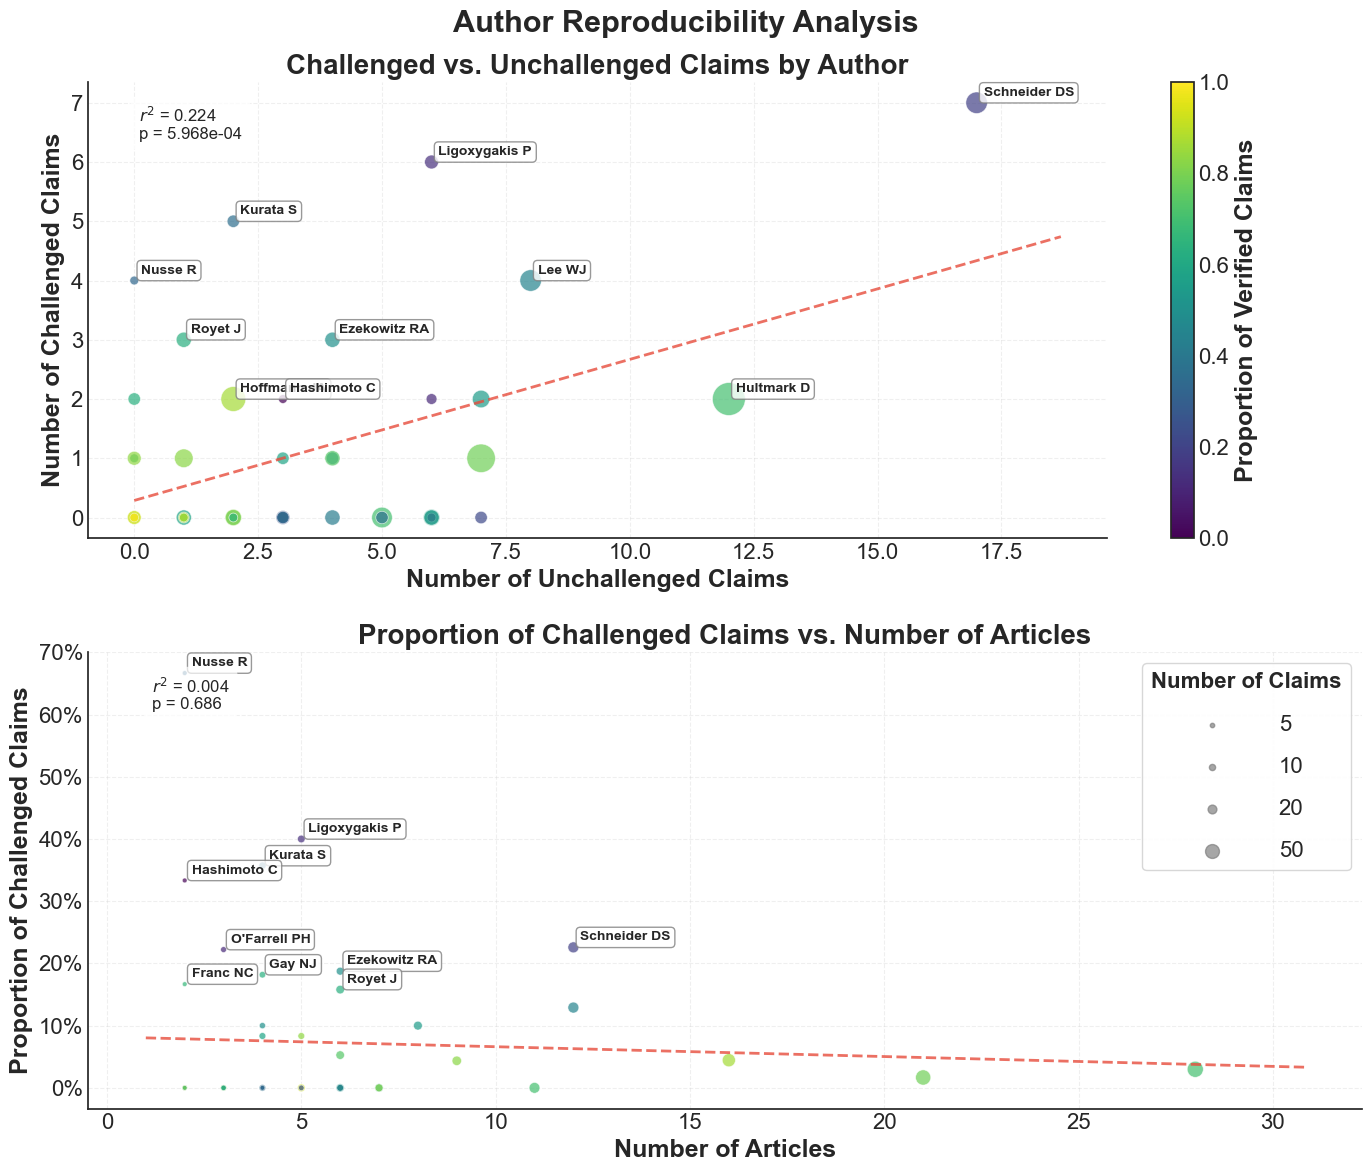

In [13]:

# Example usage for general scatter plot:
fig, ax = plot_info.create_publication_scatter(
    to_plot,
    x_var='Unchallenged', 
    y_var='Challenged',
    size_var='Articles', 
    title='Challenged vs. Unchallenged Claims by Author',
    x_label='Number of Unchallenged Claims',
    y_label='Number of Challenged Claims',
    annotate_top_n=5
)
plt.savefig(f'figures/fig6B_scatterB', dpi=300, bbox_inches='tight')
# Example usage for specialized author reproducibility plot:
fig = plot_info.create_author_reproducibility_scatter(
    to_plot, 
    min_articles=1, 
    min_claims=1,
    annotate_top_n=10
)

# Save examples:
plt.savefig(f'figures/fig5C_scatterB', dpi=300, bbox_inches='tight')
#plt.savefig('author_reproducibility.pdf', bbox_inches='tight')

### Things that uses both

In [14]:
first_author_claims = pd.read_csv("preprocessed_data/first_author_claims.csv")

In [15]:
all_claims = pd.merge(first_author_claims, leading_author_claims, on='id', how='outer', suffixes=('_first', '_last'))

In [16]:
import preprocess_utils


## B. Binary variables

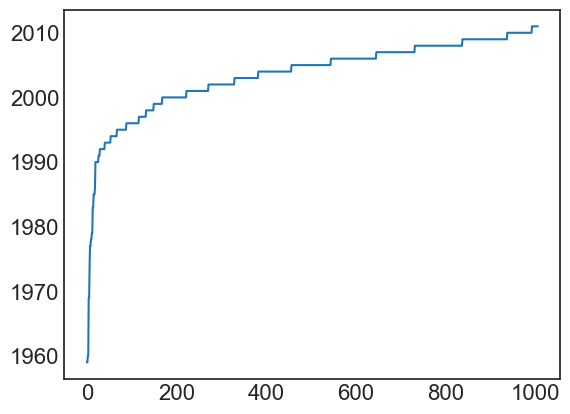

In [17]:
first_papers_year = {}
claims_sorted = preprocess_utils.build_author_key(leading_author_claims, "authors_txt", "all_authors_key")
claims_sorted = claims_sorted.sort_values(by=['year']).reset_index(drop=True)
claims_sorted["year"].plot()
for lh in leading_author_claims["last_author_key"].unique():
    found = False
    for idx, row in claims_sorted.iterrows():
        all_aut = row["all_authors_key"]
        authors_list = [aut.strip() for aut in all_aut.split(";")]
        if lh in authors_list:
            first_papers_year[lh] = row["year"]
            found = True
            break  # Break out of the inner loop once we find the first paper
    if not found:
        print(f"Warning: No papers found for author {lh}")
first_papers_year = pd.DataFrame.from_dict(first_papers_year, orient='index', columns=['first_paper_year'])

In [18]:
to_plot = pd.merge(first_papers_year, author_metrics, left_index=True, right_on='last_author_key', how='right')

/Users/chadi/Research/drosophila-reproducibility/plot_info.py:1389: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


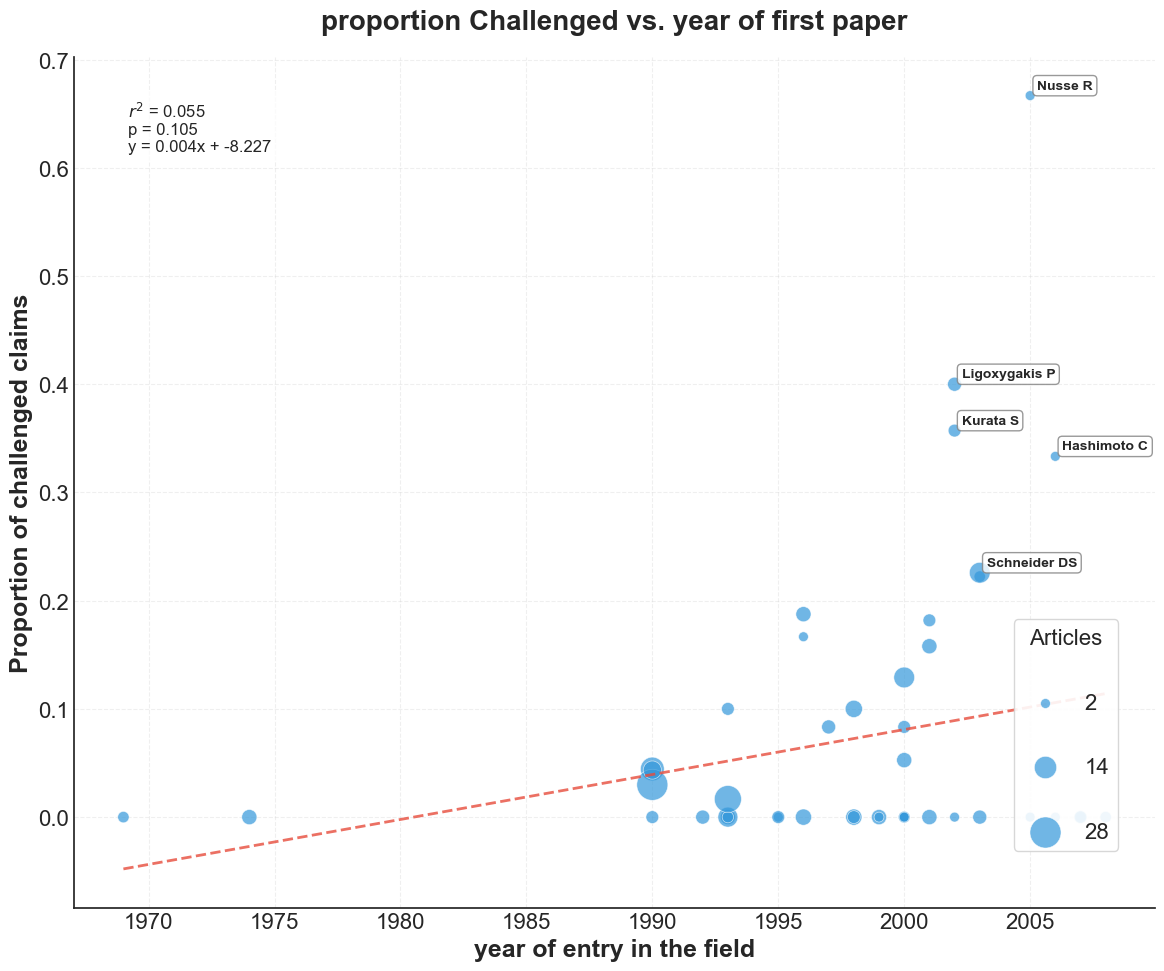

In [19]:
fig, ax = plot_info.create_publication_scatter(
    to_plot,
    x_var='first_paper_year', 
    y_var='Challenged prop',
    size_var='Articles', 
    title='proportion Challenged vs. year of first paper',
    x_label="year of entry in the field",
    y_label="Proportion of challenged claims",
    annotate_top_n=5
)
plt.savefig(f'figures/fig5X_YearVSRepro', dpi=300, bbox_inches='tight')

## Model

In [20]:
# Create a multivariable regression model to predict reproducibility
# First, ensure no object datatypes are in our dataset by examining the data
print("Data types before preprocessing:")

# Convert any object columns to appropriate types
# Make sure all numeric columns are properly formatted
numeric_cols = ['Articles', 'Unchallenged_prop', 'Challenged_prop', 'Challenged_prop']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert boolean columns to integer
bool_cols = ['Historical lab', 'Continuity']
for col in bool_cols:
    df[col] = df[col].astype(int)
    
# Make sure categorical variables are properly typed
if 'Sex' in df.columns:
    df['Sex'] = df['Sex'].astype('category')
    
# Create dummy variables properly
df_model = pd.get_dummies(df[['Historical lab', 'Continuity', 'Ivy league', 
                             'Articles', 'Unchallenged_prop', 'Challenged_prop', 
                             'Challenged_prop']])

# Print data types after preprocessing
print("Data types after preprocessing:")
print(df_model.dtypes)

# Fit regression model for unchallenged proportion
# Select predictors (X) and target (y)
y = df_model['Unchallenged_prop']
X = df_model.drop(['Unchallenged_prop', 'Challenged_prop', 'Challenged_prop'], axis=1)

# Add constant
X = sm.add_constant(X)

# Verify no object datatypes remain
print("X dtypes:", X.dtypes.unique())
print("y dtype:", y.dtype)

# Fit model
try:
    model_unchallenged = sm.OLS(y, X).fit()
    print("Model successfully fit!")
    
    # Create another model for reproducibility score
    y2 = df_model['Challenged_prop']
    model_repro = sm.OLS(y2, X).fit()
    
    # Print summaries
    print("\nRegression Model for Unchallenged Proportion:")
    print(model_unchallenged.summary())
    
    print("\nRegression Model for Reproducibility Score:")
    print(model_repro.summary())
    
    # Create a visual summary of the regression results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Extract coefficients and confidence intervals for unchallenged model
    coefs1 = model_unchallenged.params[1:]
    conf_intervals1 = model_unchallenged.conf_int().iloc[1:]
    errors1 = (conf_intervals1[1] - conf_intervals1[0]) / 3.92  # 95% CI to standard error
    
    # Plot coefficients for unchallenged model
    ax1.errorbar(coefs1, range(len(coefs1)), xerr=errors1, fmt='o', capsize=5, color='#3498db')
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax1.set_yticks(range(len(coefs1)))
    ax1.set_yticklabels(coefs1.index)
    ax1.set_xlabel('Coefficient Value')
    ax1.set_title('Predictors of Unchallenged Claims')
    
    # Extract coefficients and confidence intervals for reproducibility model
    coefs2 = model_repro.params[1:]
    conf_intervals2 = model_repro.conf_int().iloc[1:]
    errors2 = (conf_intervals2[1] - conf_intervals2[0]) / 3.92  # 95% CI to standard error
    
    # Plot coefficients for reproducibility model
    ax2.errorbar(coefs2, range(len(coefs2)), xerr=errors2, fmt='o', capsize=5, color='#2ecc71')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_yticks(range(len(coefs2)))
    ax2.set_yticklabels(coefs2.index)
    ax2.set_xlabel('Coefficient Value')
    ax2.set_title('Predictors of Reproducibility Score')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error fitting model: {e}")
    print("Let's try an alternative approach using a simpler model")
    
    # Create a simpler model with fewer variables
    basic_vars = ['Articles', 'Historical lab', 'Continuity']
    df_simple = df[basic_vars + ['Unchallenged_prop']].copy()
    
    for col in basic_vars + ['Unchallenged_prop']:
        df_simple[col] = pd.to_numeric(df_simple[col], errors='coerce')
    
    # Drop missing values
    df_simple = df_simple.dropna()
    
    # Run simpler regression
    X_simple = sm.add_constant(df_simple[basic_vars])
    y_simple = df_simple['Unchallenged_prop']
    
    model_simple = sm.OLS(y_simple, X_simple).fit()
    print("\nSimplified Regression Model:")
    print(model_simple.summary())


Data types before preprocessing:


NameError: name 'df' is not defined